<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#SVM-implementation" data-toc-modified-id="SVM-implementation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>SVM implementation</a></span><ul class="toc-item"><li><span><a href="#Generating-Data" data-toc-modified-id="Generating-Data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Generating Data</a></span></li><li><span><a href="#Accuracy" data-toc-modified-id="Accuracy-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Accuracy</a></span></li><li><span><a href="#Comparision-for-different-limit-values-C" data-toc-modified-id="Comparision-for-different-limit-values-C-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Comparision for different limit values <code>C</code></a></span></li></ul></li><li><span><a href="#Benchmark" data-toc-modified-id="Benchmark-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Benchmark</a></span></li></ul></div>

# SVM implementation



In [1]:
import numpy as np

class SVM:
    def __init__(self,C=10.,random_state=234,use_err_cache=True):
        self.rnd=np.random.RandomState(random_state)
        self.C=np.float_(C)
        self.tol=1E-3
        self.numerical_tol=1E-7
        self.use_err_cache=use_err_cache
    
    def K(self, x1, x2):
        return x1.dot(x2)

    def g(self, x, svi, alpha, b):

        if True:
            # correct for only linear kernel
            ys=self.y[svi]
            as_=self.alpha[svi]
            xs=self.X[svi]
            return np.sum(ys*as_*xs.dot(x))+b
            
        gx=0
        for t in range(svi.shape[0]):
            idx = svi[t]
            gx += self.y[idx]*alpha[idx]*self.K(x, self.X[idx])
        return gx + b
    

    def update_alpha(self, a1_old, a1_new, idx1):
        C=self.C
        svi=self.svi
        unb_svi=self.unb_svi
        
        if a1_old == 0 and a1_new > 0:
            svi=np.append(svi, idx1)
        elif a1_old > 0 and a1_new == 0:
            svi=np.delete(svi, np.argwhere(svi==idx1))
                          
        if (a1_old > 0 and a1_old < C) and not (a1_new > 0 and a1_new < C):
            unb_svi=np.delete(unb_svi, np.argwhere(unb_svi==idx1))
        elif not (a1_old > 0 and a1_old < C) and (a1_new > 0 and a1_new < C):
            unb_svi=np.append(unb_svi, idx1)
                                    
        self.svi=svi
        self.unb_svi=unb_svi
        
    def update_err(self):
        for idx in self.unb_svi:
            self.Err[idx] = self.g(self.X[idx], self.svi, self.alpha, self.b) - self.y[idx]
         
    def tune(self, idx1, idx2):
        '''
        update alpha, svi, b
        '''
        
        if idx1 == idx2:
            return False

        alpha=self.alpha
        b_old=self.b
        svi=self.svi
        C=self.C
        
        a1_old = alpha[idx1]
        a2_old = alpha[idx2]
        x1 = self.X[idx1]
        x2 = self.X[idx2]
        y1 = self.y[idx1]
        y2 = self.y[idx2]

        # calculate L and H very carefully
        if False:
            print(type(a1_old))
            print(type(a2_old))
            print(type(C))
            print("idx1, idx2", idx1, idx2)
            print("y", self.y)
            print("y1 y2", y1, y2)

        if y1 == y2:
            if a2_old == C:
                L = a1_old
            elif a1_old == C:
                L = a2_old
            else:
                L=max(0, a1_old + a2_old - C)
            # a1_old == C and a2_old == C : L = C
            # a1_old == 0 and a2_old == 0 : L = 0
            H=min(C, a1_old + a2_old)            
            # a1_old == C and a2_old == C : H = C
            # a1_old == 0 and a2_old == 0 : H = 0
        else:
            L = max(0, a2_old - a1_old)
            if a2_old == a1_old:
                H = C
            elif C == a1_old:
                H = a2_old
            else:
                H = min(C, C + a2_old - a1_old)
        #print("L H", L, H)

        # no update?
        # return
        if abs(L - H) < self.numerical_tol:
            return False

        E1 = self.g(x1, svi, alpha, b_old)-y1
        E2 = self.g(x2, svi, alpha, b_old)-y2
        K11 = self.K(x1, x1)
        K22 = self.K(x2, x2)
        K12 = self.K(x1, x2)
        K21 = K12

        # a2
        eta =  K11 + K22 - 2*K12
        a2_new_unc = a2_old + y2*(E1 - E2)/eta        
        #print("a2_new_unc", a2_new_unc)
        a2_new = max(min(a2_new_unc, H), L)

        # no update?
        # return
        if False:
            print("y1 y2", y1, y2)
            print("E1 E2", E1, E2)
            print("eta", eta)
            print("a2_new_unc", a2_new_unc)
            print("a2_new", a2_new)
            print("a2_old", a2_old)

        if abs(a2_new) < self.numerical_tol:
            a2_new=np.float_(0)
        if abs(a2_new-self.C) < self.numerical_tol:
            a2_new=self.C            

        # update a1
        a1_new = a1_old + y1*y2*(a2_old - a2_new)
        
        if abs(a1_new) < self.numerical_tol:
            a1_new=np.float_(0)
        if abs(a1_new-self.C) < self.numerical_tol:
            a1_new=self.C

        # update bias
        if 0 < a1_old and a1_old < self.C:
            b1_new = -E1 - y1*K11*(a1_new - a1_old) - y2*K21*(a2_new - a2_old) + b_old
            b_new = b1_new
        elif 0 < a2_old and a2_old < self.C:
            b2_new = -E2 - y1*K12*(a1_new - a1_old) - y2*K22*(a2_new - a2_old) + b_old            
            b_new = b2_new
        else:
            b1_new = -E1 - y1*K11*(a1_new - a1_old) - y2*K21*(a2_new - a2_old) + b_old
            b2_new = -E2 - y1*K12*(a1_new - a1_old) - y2*K22*(a2_new - a2_old) + b_old            
            b_new = 0.5*(b1_new + b2_new)

        self.update_alpha(a1_old, a1_new, idx1)
        self.update_alpha(a2_old, a2_new, idx2)
        
        self.alpha[idx1]=a1_new
        self.alpha[idx2]=a2_new
        self.b = b_new
        
        if self.use_err_cache:
            self.update_err()
        return True;
            

            
    def examineExample(self,i2):
        svi=self.svi
        alpha=self.alpha
        b=self.b
        C=self.C
                
        y2 = self.y[i2]
        a2 = alpha[i2]
        b=self.b
        
        if self.use_err_cache and a2 > 0 and a2 < C:
            E2=self.Err[i2]
        else:
            E2 = self.g(X[i2],svi,alpha,b) - y2
            
        r2 = E2*y2
        tol=self.tol
        
        if False:
            #print("E2", E2)
            #print("y2", y2)
            print("i2", i2)
            print("a2", a2)
            print("r2", r2)
            if (a2 < self.C and r2 < -tol) or (a2 > 0 and r2 > tol):
                print("kkt violation")
                
        # KKT violation
        if (a2 < C and r2 < -tol) or (a2 > 0 and r2 > tol):
            
            Nsv=svi.shape[0]
            #print(Nsv)
            Ndata=alpha.shape[0]
            #print(Ndata)
            
            if self.unb_svi.shape[0]:
                max_E1=0
                max_i1=0
                
                if self.use_err_cache:
                    es=self.Err[self.unb_svi]
                    if E2 <= 0:
                        idx=np.argmax(es)
                    else:
                        idx=np.argmin(es)
                    max_i1=self.unb_svi[idx]
                else:
                    t=0
                    for i1 in self.unb_svi:
                        E1=self.g(X[i1],svi,alpha,b) - y[i1]
                        E1=E1 if E2 <= 0 else -E1
                        if t==0 or E1 > max_E1:
                            max_E1=E1
                            max_i1=i1
                        t+=1
                if self.tune(max_i1, i2):
                    #print("done max_i1",i1)
                    return 1
            
            # our heuristic choice does not work
            # loop over all non-zero and non-C alpha, starting at a random point
            if Nsv > 0:
                start=self.rnd.randint(Nsv)
                #print(start)
                # we will return immediately if Nsv changes
                # so it's OK
                for t in range(start, Nsv):
                    i1=svi[t]
                    if 0 < alpha[i1] and alpha[i1] < self.C:
                        if self.tune(i1, i2):
                            #print("done max_i1",i1)
                            return 1
                for i1 in range(0, start):
                    i1=svi[t]
                    if 0 < alpha[i1] and alpha[i1] < self.C:
                        if self.tune(i1, i2):
                            #print("done max_i1",i1)
                            return 1


            # loop over all possible i1, starting at a random point
            start=self.rnd.randint(Ndata)
            for i1 in range(start, Ndata):                
                #print("all possible i1", i1)
                if self.tune(i1, i2):
                    #print("done i1", i1)
                    return 1
            for i1 in range(0, start):
                #print("all possible i1", i1)
                if self.tune(i1, i2):
                    #print("done i1", i1)
                    return 1
        return 0
        
    def fit(self, X, y):
        assert X.ndim == 2, X.shape
        assert y.ndim == 1, y.shape
        assert X.shape[0] == y.shape[0], (X.shape, y.shape)

        
        # transform to -1,+1
        yset = set(y)
        yarr=list(yset)
        yarr.sort()
        assert len(yarr) == 2, yarr
        yb = np.zeros(y.shape[0],dtype=np.int_)
        yb[y==yarr[0]]=-1
        yb[y==yarr[1]]=+1
        y=yb

        Ndata = X.shape[0]
        
        self.yarr=yarr
        self.X=X
        self.y=y
        self.svi=np.array([],dtype=np.int_)
        self.unb_svi=np.array([],dtype=np.int_)
        self.b=np.float_(0)
        self.alpha=np.zeros(Ndata,dtype=np.float_)
        if self.use_err_cache:
            self.Err=np.zeros(Ndata,dtype=np.float_)
        
        # Dual problem
        # Minimize 0.5* sum_{i,j} alpha_i alpha_j y_i y_j K(x_i,y_j) - sum_i alphga_i
        # sum_i alpha_i y_i = 0
        # 0 <= alpha_i <= C        
        # SMO
        
        
        while True:
            
            # examine all examples
            numChanged=0
            for i2 in range(self.alpha.shape[0]):
                numChanged += self.examineExample(i2)
            if numChanged==0:
                break
            #print("all numChanged", numChanged)

            # examine unbound examples
            while True:
                numChanged=0
                change_list=[]
                t=0
                while t < self.svi.shape[0]:
                    #print("t", t)
                    i2=self.svi[t]
                    if 0 < self.alpha[i2] and self.alpha[i2] < self.C:
                        n=self.examineExample(i2)
                        numChanged += n
                        if n:
                            change_list.append(i2)
                    t += 1
                #print("unbound numChanged", numChanged, change_list)
                if numChanged == 0:
                    break
                    
                    
        self.coef_=np.zeros(X.shape[1],dtype=np.float_)        
        for i in range(self.svi.shape[0]):
            idx=self.svi[i]
            self.coef_+=self.alpha[idx]*self.y[idx]*self.X[idx]
            
        self.intercept_=self.b
        

    def predict(self,X):
        b=self.b
        alpha=self.alpha
        svi=self.svi
        
        yhat=np.zeros(X.shape[0], dtype=np.int_)
        for i in range(X.shape[0]):
            if np.sign(self.g(X[i],svi,alpha,b)) < 0:
                yhat[i] = self.yarr[0]
            else:
                yhat[i] = self.yarr[1]
        return yhat


## Generating Data

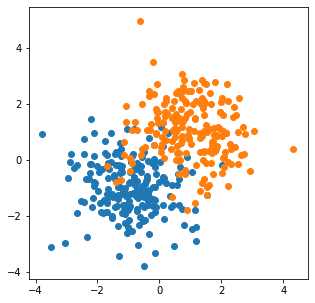

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


def gen_data(center,n=200,random_state=1):
    rnd=np.random.RandomState(random_state)

    if isinstance(n, int):        
        Xs=[rnd.randn(n,2) + c for c in center]
        ys=[np.full(n, i) for i in range(len(center))]
    else:
        assert len(n) == len(center), n
        Xs=[rnd.randn(n_,2) + c for c,n_ in zip(center,n)]
        ys=[np.full(n_, i) for i,n_ in enumerate(n)]
        
    X=np.vstack(Xs)
    y=np.hstack(ys)
    pert=np.random.permutation(X.shape[0])
    X=X[pert]
    y=y[pert]
    
    return X,y

def plot_data(X, y):
    plt.figure(figsize=(5,5))
    nlabels=int(np.amax(y)+1)
    for i in range(nlabels):        
        plt.scatter(X[y==i,0], X[y==i,1])
        
    plt.show()

X,y=gen_data([[-1,-1],[1,1]])
plot_data(X, y)

## Accuracy

accuracy: 0.930


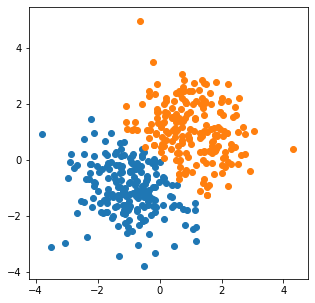

In [3]:
np.random.seed(0)

X,y=gen_data([[-1,-1],[1,1]],n=200)
svm=SVM(C=1)
svm.fit(X, y)

X,y=gen_data([[-1,-1],[1,1]],n=200)
yhat=svm.predict(X)

print("accuracy: %.3f"%(np.sum(yhat==y)/y.shape[0]))
plot_data(X, yhat)

## Comparision for different limit values `C`

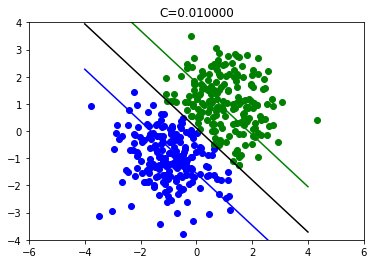

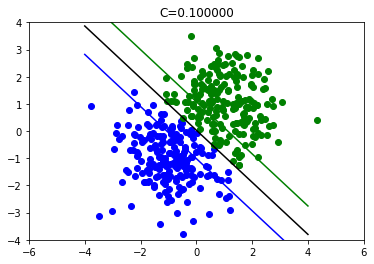

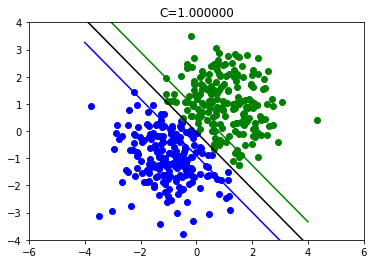

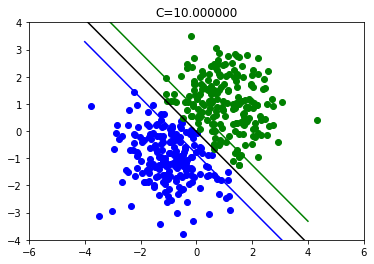

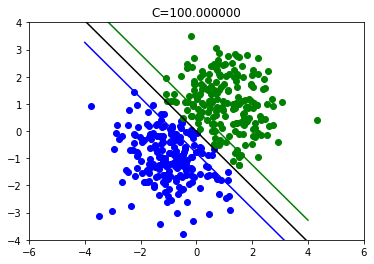

In [4]:
def plot(C=1):
    
    svm=SVM(C)
    svm.fit(X,y)
    yhat=svm.predict(X)

    plt.figure()
    plt.scatter(X[yhat==0,0], X[yhat==0,1],color="blue")
    plt.scatter(X[yhat==1,0], X[yhat==1,1],color="green")
    x_plt=np.linspace(-4,4,10)
    y_plt=(x_plt*svm.coef_[0]+svm.intercept_)/(-svm.coef_[1])
    plt.plot(x_plt, y_plt, color="black")

    x_plt=np.linspace(-4,4,10)
    y_plt=(x_plt*svm.coef_[0]+svm.intercept_ + 1)/(-svm.coef_[1])
    plt.plot(x_plt, y_plt,"blue")

    x_plt=np.linspace(-4,4,10)
    y_plt=(x_plt*svm.coef_[0]+svm.intercept_ - 1)/(-svm.coef_[1])
    plt.plot(x_plt, y_plt,"green")

    plt.xlim(-6,6)
    plt.ylim(-4,4)
    plt.title(("C=%f"%C))
    plt.show()
    
    #print(svm.alpha[svm.svi])
    #print(svm.alpha[svm.unb_svi])
    

plot(0.01)
plot(0.1)
plot(1)
plot(10)
plot(100)


# Benchmark

In [5]:
#import profile
#C=SVM(10,use_err_cache=False)
#profile.run("C.fit(X,y)")
#C=SVM(10,use_err_cache=True)
#profile.run("C.fit(X,y)")